<a href="https://colab.research.google.com/github/ocean8800v/manuscript-pipeline/blob/main/3_complexity_response_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==2.2.2 torch==2.8.0 transformers==4.55.2 tqdm==4.67.1 jieba==0.42.1 wordfreq==3.1.1 scikit-learn==1.6.1 numpy==2.0.2 palettable==3.3.3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import re
import math
import torch
import jieba
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from wordfreq import word_frequency
from matplotlib.colors import Normalize
from sklearn.preprocessing import StandardScaler
from palettable.colorbrewer.diverging import RdBu_11
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel

In [ ]:
# ========== Response Quality ==========

df_four = pd.read_csv("/content/drive/MyDrive/manuscript/3_split_data/stacked_test.csv")
df_charls = pd.read_csv("/content/drive/MyDrive/manuscript/3_split_data/charls_test.csv")
output_path = "/content/drive/MyDrive/manuscript/4_results/6_Complexity_Response_Quality/result_response_quality.csv"
df = pd.concat([df_four, df_charls], ignore_index=True)

lqr_columns = ['asinmiss', 'extreme', 'gnorm', 'logresvar', 'lz', 'mdistance', 'u3']

scaler = StandardScaler()
df[lqr_columns] = scaler.fit_transform(df[lqr_columns])

indicators_to_reverse = ['asinmiss', 'extreme', 'gnorm', 'logresvar', 'mdistance', 'u3']
df[indicators_to_reverse] = -df[indicators_to_reverse]

df['LQR_composite'] = df[lqr_columns].mean(axis=1)

df['Quality_Percentile'] = rankdata(df['LQR_composite'], method='average') / len(df) * 100
df['Quality_Percentile'] = df['Quality_Percentile'].round(3)

scale_quality_summary = df.groupby(['country', 'scale']).agg(
    Quality_Percentile=('Quality_Percentile', 'mean'),
    N=('Quality_Percentile', 'count')
).reset_index()

scale_quality_summary['Quality_Percentile'] = scale_quality_summary['Quality_Percentile'].round(1)
scale_quality_summary.to_csv(output_path, index=False)

In [ ]:
# ========== Text Complexity ==========

input_path = '/content/drive/MyDrive/manuscript/4_results/6_Complexity_Response_Quality/psychosocial_scales_questions.csv'
output_path = '/content/drive/MyDrive/manuscript/4_results/6_Complexity_Response_Quality/result_complexit.csv'

data = pd.read_csv(input_path)
# Multiple languages text cleaning
def clean_text(text, language):
    if language == 'CHARLS':
        return ''.join(re.findall(r'[\u4e00-\u9fff]+', text))
    elif language in ['HRS', 'ELSA']:
        return ' '.join(re.findall(r'\b[a-zA-Z]+\b', text))
    elif language == 'MHAS':
        return ' '.join(re.findall(r'\b[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ]+\b', text))
    elif language == 'LASI':
        return text
    else:
        return text

data['clean_question_text'] = data.apply(lambda row: clean_text(row['question_text'], row['country']), axis=1)

# Load models
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
mlm_model = AutoModelForMaskedLM.from_pretrained(model_name).cuda().eval()
embed_model = AutoModel.from_pretrained(model_name).cuda().eval()

# Perplexity calculation function
def calculate_perplexity(sentence, tokenizer, model):
    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True).to('cuda')
        outputs = model(**inputs, labels=inputs.input_ids)
        return torch.exp(outputs.loss).item()

tqdm.pandas(desc="Calculating Perplexity")
data['Perplexity'] = data['question_text'].progress_apply(lambda x: calculate_perplexity(x, tokenizer, mlm_model))

# Difficult word ratio calculation function
def difficult_word_ratio_multilingual(text, language, threshold=1e-5):
   if language == 'CHARLS':
       words, lang_code = list(jieba.cut(text)), 'zh'
   elif language == 'LASI':
       words, lang_code = text.split(), 'hi'
   elif language == 'MHAS':
       words, lang_code = re.findall(r'\b[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ]+\b', text.lower()), 'es'
   else:
       words, lang_code = re.findall(r'\b[a-zA-Z]+\b', text.lower()), 'en'

   if not words:
       return 0.0
   return len([w for w in words if word_frequency(w, lang_code) < threshold]) / len(words)

data['Difficult_Word_Ratio'] = data.apply(lambda row: difficult_word_ratio_multilingual(row['clean_question_text'], row['country']), axis=1)

# Semantic rarity calculation function
def get_embedding(text, tokenizer, model):
   with torch.no_grad():
       inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to('cuda')
       outputs = model(**inputs)
       return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

tqdm.pandas(desc="Calculating Embeddings")
embeddings = data['clean_question_text'].progress_apply(lambda x: get_embedding(x, tokenizer, embed_model))
embedding_matrix = np.stack(embeddings.values)

similarity_matrix = cosine_similarity(embedding_matrix)
np.fill_diagonal(similarity_matrix, 0)
data['Semantic_Rarity'] = 1 - similarity_matrix.mean(axis=1)

# Aggregate indicators by country and scale (Overall Sum only)
summary = data.groupby(['country', 'scale']).agg(
   Perplexity_Sum=('Perplexity', 'sum'),
   DWR_Sum=('Difficult_Word_Ratio', 'sum'),
   Semantic_Rarity_Sum=('Semantic_Rarity', 'sum')
).reset_index()

# Calculate Z-scores
for col in ['Perplexity_Sum', 'DWR_Sum', 'Semantic_Rarity_Sum']:
   summary[f'{col}_Overall_Z'] = (summary[col] - summary[col].mean()) / summary[col].std()

summary['Composite_Overall_Z'] = (
    (1/3) * summary['Perplexity_Sum_Overall_Z'] +
    (1/3) * summary['DWR_Sum_Overall_Z'] +
    (1/3) * summary['Semantic_Rarity_Sum_Overall_Z']
)
# Define complexity rating based on weighted sum
def categorize_complexity(z):
    if z > 0.5:
        return 'High'
    elif z < -0.5:
        return 'Low'
    else:
        return 'Medium'

summary['Complexity_Overall'] = summary['Composite_Overall_Z'].apply(categorize_complexity)

summary['Complexity_Percentile(%)'] = rankdata(summary['Composite_Overall_Z'], method='average') / len(summary) * 100
summary['Complexity_Percentile(%)'] = summary['Complexity_Percentile(%)'].round(1)

summary['Semantic_Rarity_Percentile'] = (rankdata(summary['Semantic_Rarity_Sum'], method='average') / len(summary) * 100).round(1)
country_order = ['HRS', 'ELSA', 'LASI', 'MHAS', 'CHARLS']
summary['country'] = pd.Categorical(summary['country'], categories=country_order, ordered=True)
summary = summary.sort_values(['country', 'scale']).reset_index(drop=True)
summary.to_csv(output_path, index=False)

In [ ]:
# ========== Merge Analysis Data ==========

# Load the unified model performance dataset for four countries
df1 = pd.read_csv('/content/drive/MyDrive/manuscript/4_results/1_Defualt/Defualt_Model_Performance/unified_model/Group1_scale_4countries.csv')
df1_test = df1[df1['subset'] == 'test'][[
    'country', 'scale', 'ROC_AUC_Macro', 'ROC_AUC_Normal',
    'ROC_AUC_MCI', 'ROC_AUC_Dementia', 'sample_size'
]]

# Load the CHARLS scale-specific unified model performance dataset
df_charls = pd.read_csv('/content/drive/MyDrive/manuscript/4_results/1_Defualt/Defualt_Model_Performance/unified_model/all_groups_CHARLS_scale_test.csv')
df_charls_group1 = df_charls[df_charls['group'] == 'Group1'][[
    'country', 'scale', 'ROC_AUC_Macro', 'ROC_AUC_Normal',
    'ROC_AUC_MCI', 'ROC_AUC_Dementia', 'sample_size'
]]


df_auc = pd.concat([df1_test, df_charls_group1], ignore_index=True)

df_complexity = pd.read_csv('/content/drive/MyDrive/manuscript/4_results/6_Complexity_Response_Quality/result_complexit.csv')
df_quality = pd.read_csv('/content/drive/MyDrive/manuscript/4_results/6_Complexity_Response_Quality/result_response_quality.csv')

df_auc['Complexity_Percentile(%)'] = df_complexity['Complexity_Percentile(%)']
df_auc['Quality_Percentile'] = df_quality['Quality_Percentile']

df_auc = df_auc.rename(columns={
    'ROC_AUC_Macro': 'Macro_AUROC',
    'ROC_AUC_Normal': 'Cognitive_Impairment_AUROC',
    'ROC_AUC_MCI': 'MCI_AUROC',
    'ROC_AUC_Dementia': 'Dementia_AUROC'
})

df_auc.to_csv('/content/drive/MyDrive/manuscript/4_results/6_Complexity_Response_Quality/AUC_complexit_response_quality.csv', index=False)

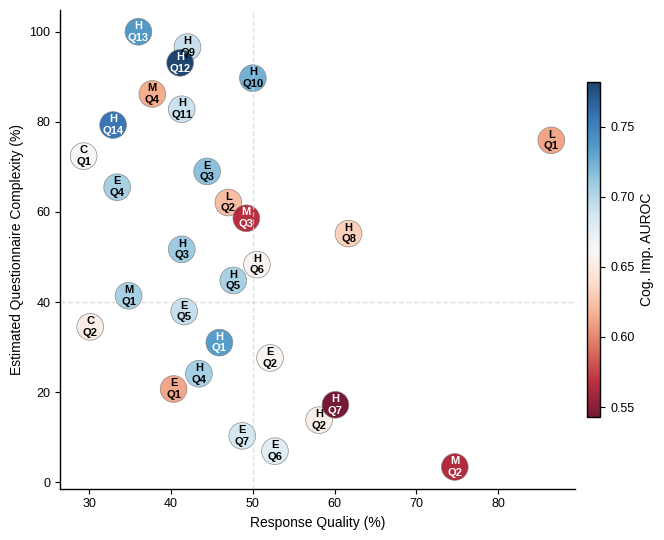

In [3]:
# ========== Plot ==========
plt.style.use("default")
plt.rcParams.update({
    "font.family": "Liberation Sans",
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "axes.facecolor": "white",
})

data = pd.read_csv("/content/drive/MyDrive/manuscript/4_results/6_Complexity_Response_Quality/AUC_complexit_response_quality.csv")

cmap = RdBu_11.mpl_colormap
vmin = data['Cognitive_Impairment_AUROC'].min()
vmax = data['Cognitive_Impairment_AUROC'].max()
norm = Normalize(vmin=vmin, vmax=vmax)

bubble_size = 370

country_mapping = {
    "HRS": "H",
    "ELSA": "E",
    "LASI": "L",
    "MHAS": "M",
    "CHARLS": "C"
}

def get_contrast_color(rgb):
    brightness = np.sqrt(0.299 * rgb[0]**2 + 0.587 * rgb[1]**2 + 0.114 * rgb[2]**2)
    return 'black' if brightness > 0.6 else 'white'

fig, ax = plt.subplots(figsize=(7, 5.5))

ax.axvline(x=50, color='lightgray', linestyle='--', linewidth=1, alpha=0.7)
ax.axhline(y=40, color='lightgray', linestyle='--', linewidth=1, alpha=0.7)

scatter = ax.scatter(
    data['Quality_Percentile'],
    data['Complexity_Percentile(%)'],
    s=bubble_size,
    c=data['Cognitive_Impairment_AUROC'],
    cmap=cmap,
    norm=norm,
    edgecolors='gray',
    linewidth=0.5,
    alpha=0.9
)

for i, row in data.iterrows():
    x, y = row['Quality_Percentile'], row['Complexity_Percentile(%)']
    abbr = country_mapping.get(row['country'], row['country'])

    scale_name = row['scale']
    if not str(scale_name).startswith('Q'):
        scale_name = f"Q{scale_name}"

    label = f"{abbr}\n{scale_name}"
    rgb = cmap(norm(row['Cognitive_Impairment_AUROC']))[:3]

    ax.text(x, y, label, fontsize=8,
            linespacing=1.2,
            ha='center', va='center',
            color=get_contrast_color(rgb),
            weight='bold')

ax.set_xlabel('Response Quality (%)', fontsize=10)
ax.set_ylabel('Estimated Questionnaire Complexity (%)', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=9)

cbar = plt.colorbar(scatter, ax=ax,
                   shrink=0.7,
                   aspect=25,
                   pad=0.02)
cbar.set_label('Cog. Imp. AUROC', fontsize=10)
cbar.ax.tick_params(labelsize=9)
plt.tight_layout()

output_path = "/content/drive/MyDrive/manuscript/4_results/6_Complexity_Response_Quality/complexity_quality_auroc_plot.pdf"
plt.savefig(output_path,
            bbox_inches="tight",
            facecolor="white",
            format='pdf',
            pad_inches=0.1)

plt.show()